In [20]:
import matplotlib
# %matplotlib inline
# print("BACKEND: ", matplotlib.get_backend())
# if matplotlib.get_backend() != "macosx":
#   print("Changing backend to macosx")
#   matplotlib.use('macosx')


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase.visualize import view

from ase import Atoms
from ase.build import bulk
from ase.io import read, write
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

In [22]:
from agox.models.descriptors.fingerprint import Fingerprint
from agox.models.descriptors import Voronoi
import numpy as np

template = Atoms("", cell=np.eye(3) * 3.567, pbc=True)
diamond = bulk("C", "diamond", a=3.567)  # Lattice constant for diamond cubic carbon
confinement_cell = template.cell.copy()
confinement_corner = np.array([0, 0, 0])
environment = Environment(
    template=template,
    symbols="C8",
    confinement_cell=confinement_cell,
    confinement_corner=confinement_corner,
    box_constraint_pbc=[True, True, True],  # Confinement is periodic in all directions.
)
descriptor = Fingerprint(environment=environment)
graph_descriptor = Voronoi(
    covalent_bond_scale_factor=1.3, n_points=8, angle_from_central_atom=20, environment=environment
)


╭───────────────────────────── Environment report ─────────────────────────────╮
│ Atoms in search:                                                             │
│     C = 8                                                                    │
│ Template formula:                                                            │
│ Full formula: C8                                                             │
│ Cell:                                                                        │
│     3.57 0.00 0.00                                                           │
│     0.00 3.57 0.00                                                           │
│     0.00 0.00 3.57                                                           │
│ Periodicity:                                                                 │
│     True True True                                                           │
│ Box constraint: True                                                         │
│ Confinement corner                                                           │
│     0.00 0.00 0.00                                                           │
│ Confinement cell:                                                            │
│     3.57 0.00 0.00                                                           │
│     0.00 3.57 0.00                                                           │
│     0.00 0.00 3.57                                                           │
╰──────────────────────────────────────────────────────────────────────────────╯

In [23]:
# import glob
from chgnet.model import CHGNetCalculator
calc = CHGNetCalculator()
# # for each POSCAR_[0-9] in iteration*/, read in to Atoms() object and attach calculator
# poscar_files = glob.glob("iteration*/POSCAR_[0-9]")
# atoms_list = []
# for poscar_file in poscar_files:
#   atoms = read(poscar_file)
#   atoms.calc =calc
#   atoms_list.append(atoms)


CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda


In [24]:
graph_sorting = Analysis(descriptor=graph_descriptor, directories=["."], sample_size=100)

In [25]:
seed = 0
rlxd_string = "unrlxd"

In [26]:
structures = read("DTMP/"+rlxd_string+"_structures_seed"+str(seed)+".traj", index=":")
for structure in structures:
  structure.calc = calc

In [27]:
unique, count = graph_sorting.sort_structures(structures=structures)
print("Repeats of unique structures: ", count)

Total number of structures: 1000
Number of unique structures: 100
Repeats of unique structures:  [34, 21, 3, 2, 7, 3, 13, 2, 3, 3, 1, 15, 2, 6, 2, 1, 4, 3, 1, 1, 1, 1, 1, 4, 2, 1, 1, 8, 2, 1, 1, 1, 1, 4, 10, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [28]:
# Calculate energies per atom for each unique structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in unique]
delta_en_per_atom = np.array(energies_per_atom) - (-9.064090728759766)


In [29]:
if abs( np.min(energies_per_atom) + 9.064090728759766 ) > 1e-4:
  print("Minimum energy per atom is not zero. Check the energy calculation.")
  exit()

Minimum energy per atom is not zero. Check the energy calculation.


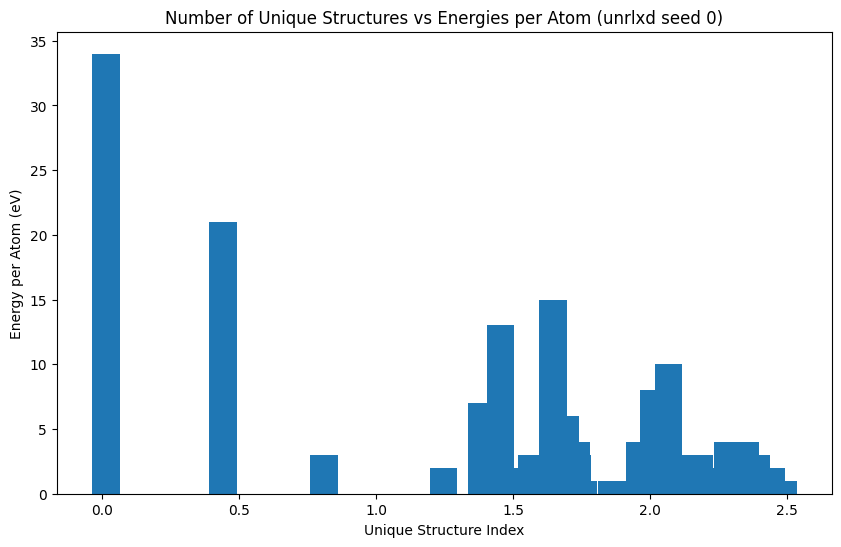

: 

In [ ]:

# Plot the number of unique structures vs the energies per atom
plt.figure(figsize=(10, 6))
plt.bar(delta_en_per_atom, count, width=0.1)
plt.xlabel('Unique Structure Index')
plt.ylabel('Energy per Atom (eV)')
plt.title('Number of Unique Structures vs Energies per Atom ('+rlxd_string+' seed '+str(seed)+')')
# plt.show()
plt.savefig("unique_structures_vs_energies_per_atom_"+rlxd_string+"_seed"+str(seed)+".png")

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=2)

In [14]:
# graph_descriptor.get_features(unique[0])
if rlxd_string == "unrlxd" and seed == 0:
  pca.fit(np.squeeze([arr for arr in descriptor.get_features(unique)]))

In [15]:
# save pca model
import pickle
if rlxd_string == "unrlxd" and seed == 0:
  with open("pca_model_"+rlxd_string+"_"+str(seed)+".pkl", "wb") as f:
    pickle.dump(pca, f)

# load pca model
with open("pca_model_unrlxd_0.pkl", "rb") as f:
  pca = pickle.load(f)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
print(pca.singular_values_)
print(pca.components_)
print(pca.mean_)
print(pca.n_features_in_)

[0.53928722 0.13634703]
[4.96849607 1.25617607]
[22.17839288 11.15174564]
[[ 4.17688505e-17 -7.63698937e-07 -7.88081193e-05 -1.29122060e-03
  -8.35110402e-03 -1.98757276e-02 -2.76953857e-03  4.33407818e-02
   3.48648917e-02 -3.07438100e-02 -7.01537511e-02 -3.43753824e-02
   3.40838262e-02  5.69803622e-02  5.16634185e-02  1.47616744e-02
  -3.72153730e-02 -5.36730065e-02 -3.11242764e-02 -3.99789491e-03
   7.59854102e-03  2.99610431e-02  3.73631562e-02  7.70994728e-03
  -2.22014876e-02 -1.46647387e-02  7.30228929e-03  1.16097057e-02
   2.56620291e-03 -2.12956259e-02 -2.85442836e-02 -4.87354478e-02
  -1.49674038e-02  4.82987251e-02  1.07983914e-01  1.15521654e-01
   8.05275147e-02  8.18769350e-02  1.52374305e-01  1.88176431e-01
   6.13949503e-02 -1.75992262e-01 -2.92372811e-01 -1.30488101e-01
   1.96508538e-01  4.30010752e-01  4.49130676e-01  3.39154986e-01
   2.07600192e-01  6.09371118e-02 -1.08652741e-01 -2.21668000e-01
  -1.79779544e-01 -7.64601241e-03  1.44193584e-01  1.58964793e-01
  

In [16]:
X_reduced = pca.transform(np.squeeze([arr for arr in descriptor.get_features(unique)]))

In [17]:
plt.figure(1, figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

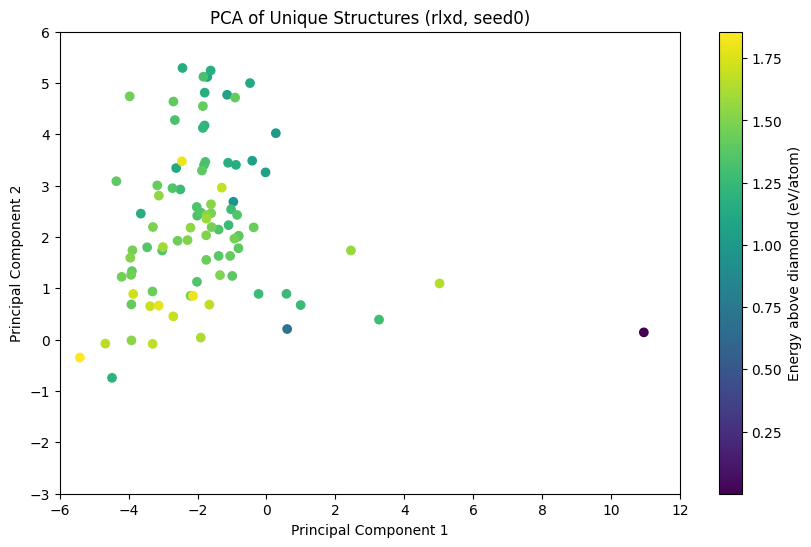

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=delta_en_per_atom, cmap="viridis")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Unique Structures ('+rlxd_string+', seed'+str(seed)+')')
plt.xlim(-6, 12)
plt.ylim(-3, 6)
plt.colorbar(label='Energy above diamond (eV/atom)')
plt.savefig('pca_unique_structures_'+rlxd_string+'_seed'+str(seed)+'.png')

In [19]:
print(np.min(energies_per_atom))

-9.06408977508545
